1. Бизнес-цели для решения задач
регрессии - предсказание цены страховки (целевой столбец - charges)
классификации - определить цену страховки в категориальных параметрах (низкая, высокая, нормальная) на основе средней цены

2. Достижимый уровень качества
данный датасет не требует от человека применения сложных средств и методов для разметки данных. Также я буду исходить из идеи, что все необходимые сведения предоставлены. Исхрдя из этого можно сказать, что модель может достичь "хорошего" уровня (цитата из презентации)

3. Выбор ориентира
регрессия - средняя стоимость страховки
классификация - наиболее часто встречающаяся категория

Подготовка данных (взято из 3 ЛР)

In [1]:
import pandas as pd
df = pd.read_csv("../dataset.csv")
print(df.shape[0])

print("было ", df.shape[0])
for column in df.select_dtypes(include=['int', 'float']).columns:
    mean = df[column].mean()
    std_dev = df[column].std()
    print(column, mean, std_dev)
    
    lower_bound = mean - 3 * std_dev
    upper_bound = mean + 3 * std_dev
    
    df = df[(df[column] <= upper_bound) & (df[column] >= lower_bound)]
    
print("стало ", df.shape[0])
df = pd.get_dummies(df, columns=['smoker', 'sex', 'region'])
df = df.reset_index(drop=True)

2772
было  2772
age 39.10966810966811 14.081459420836477
bmi 30.70134920634921 6.1294486949652205
children 1.1026753434562546 1.2157555494600176
charges 13325.498588795157 12200.175109274192
стало  2710


5-6. Выбор моделей и построение конвеера

In [6]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

X_reg = df.drop(columns=['charges'])
y_reg = df['charges']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=13)

models_reg = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42)
}

pipelines_reg = {}
for name, model in models_reg.items():
    pipelines_reg[name] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

param_grids_reg = {
    'Linear Regression': {},
    'Random Forest Regressor': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30]
    },
    'Gradient Boosting Regressor': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
}

best_models_reg = {}
for name, pipeline in pipelines_reg.items():
    grid_search = GridSearchCV(pipeline, param_grids_reg[name], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_reg, y_train_reg)
    best_models_reg[name] = grid_search.best_estimator_
    print(f'Best parameters for {name}: {grid_search.best_params_}')

results_reg = {}
for model_name in best_models_reg.keys():
    print(f"Model: {model_name}")
    model_pipeline = best_models_reg[model_name]

    y_train_predict = model_pipeline.predict(X_train_reg)
    y_test_predict = model_pipeline.predict(X_test_reg)

    results_reg[model_name] = {
        "pipeline": model_pipeline,
        "preds_train": y_train_predict,
        "preds_test": y_test_predict,
        "MSE_train": mean_squared_error(y_train_reg, y_train_predict),
        "MSE_test": mean_squared_error(y_test_reg, y_test_predict),
        "R2_train": r2_score(y_train_reg, y_train_predict),
        "R2_test": r2_score(y_test_reg, y_test_predict),
        "MAE_train": mean_absolute_error(y_train_reg, y_train_predict),
        "MAE_test": mean_absolute_error(y_test_reg, y_test_predict)
    }

for model_name, results in results_reg.items():
    print(f"Results for {model_name}:")
    print(f"MSE_train: {results['MSE_train']}")
    print(f"MSE_test: {results['MSE_test']}")
    print(f"R2_train: {results['R2_train']}")
    print(f"R2_test: {results['R2_test']}")
    print(f"MAE_train: {results['MAE_train']}")
    print(f"MAE_test: {results['MAE_test']}")


Best parameters for Linear Regression: {}
Best parameters for Random Forest Regressor: {'model__max_depth': None, 'model__n_estimators': 200}
Best parameters for Gradient Boosting Regressor: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200}
Model: Linear Regression
Model: Random Forest Regressor
Model: Gradient Boosting Regressor
Results for Linear Regression:
MSE_train: 34444659.26088208
MSE_test: 34814365.10649261
R2_train: 0.7519227670167513
R2_test: 0.7526515685852002
MAE_train: 4063.4298138535955
MAE_test: 4177.000255554095
Results for Random Forest Regressor:
MSE_train: 1068690.9196129853
MSE_test: 6893069.254237878
R2_train: 0.9923030771114929
R2_test: 0.9510262541782973
MAE_train: 458.22401190138396
MAE_test: 1239.9530445735054
Results for Gradient Boosting Regressor:
MSE_train: 314879.3352948071
MSE_test: 5789682.017738877
R2_train: 0.9977321768918687
R2_test: 0.9588655785881008
MAE_train: 241.34572975609007
MAE_test: 870.203742123879


In [11]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score, confusion_matrix, f1_score, matthews_corrcoef, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Предположим, что у вас уже есть DataFrame df с колонкой 'charges'
# df = pd.read_csv('your_data.csv')

# Вычисляем 33-й и 66-й перцентили
bins = [float('-inf'), df['charges'].quantile(0.33), df['charges'].quantile(0.66), float('inf')]
labels = ['Low', 'Medium', 'High']

# Создаем новый столбец 'ChangesGroup' на основе заданных границ
df['ChangesGroup'] = pd.cut(df['charges'], bins=bins, labels=labels)

# Преобразуем категориальные данные в числовые
df['ChangesGroup'] = df['ChangesGroup'].cat.codes

# Выбор признаков и целевой переменной для классификации
X_class = df.drop(['charges', 'ChangesGroup'], axis=1)
y_class = df['ChangesGroup']

# Разделение данных
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=13)

# Выбор моделей для классификации
models_class = {
    'Logistic Regression': LogisticRegression(random_state=13, max_iter=5000, solver='liblinear'),
    'Random Forest Classifier': RandomForestClassifier(random_state=13),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=13)
}

# Создание конвейера для классификации
pipelines_class = {}
for name, model in models_class.items():
    pipelines_class[name] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

# Определение сетки гиперпараметров для классификации
param_grids_class = {
    'Logistic Regression': {
        'model__C': [0.1, 1, 10],
        'model__solver': ['lbfgs', 'liblinear']
    },
    'Random Forest Classifier': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30]
    },
    'Gradient Boosting Classifier': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
}

# Настройка гиперпараметров для классификации
best_models_class = {}
for name, pipeline in pipelines_class.items():
    grid_search = GridSearchCV(pipeline, param_grids_class[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_class, y_train_class)
    best_models_class[name] = {"model": grid_search.best_estimator_}
    print(f'Best parameters for {name}: {grid_search.best_params_}')

# Обучение моделей и оценка качества
for model_name in best_models_class.keys():
    print(f"Model: {model_name}")
    model = best_models_class[model_name]["model"]

    model_pipeline = Pipeline([("scaler", StandardScaler()), ("model", model)])
    model_pipeline = model_pipeline.fit(X_train_class, y_train_class)

    y_train_predict = model_pipeline.predict(X_train_class)
    y_test_probs = model_pipeline.predict_proba(X_test_class)
    y_test_predict = model_pipeline.predict(X_test_class)

    best_models_class[model_name]["pipeline"] = model_pipeline
    best_models_class[model_name]["probs"] = y_test_probs
    best_models_class[model_name]["preds"] = y_test_predict

    best_models_class[model_name]["Precision_train"] = precision_score(y_train_class, y_train_predict, average='weighted')
    best_models_class[model_name]["Precision_test"] = precision_score(y_test_class, y_test_predict, average='weighted')
    best_models_class[model_name]["Recall_train"] = recall_score(y_train_class, y_train_predict, average='weighted')
    best_models_class[model_name]["Recall_test"] = recall_score(y_test_class, y_test_predict, average='weighted')
    best_models_class[model_name]["Accuracy_train"] = accuracy_score(y_train_class, y_train_predict)
    best_models_class[model_name]["Accuracy_test"] = accuracy_score(y_test_class, y_test_predict)
    best_models_class[model_name]["ROC_AUC_test"] = roc_auc_score(y_test_class, y_test_probs, multi_class='ovr')
    best_models_class[model_name]["F1_train"] = f1_score(y_train_class, y_train_predict, average='weighted')
    best_models_class[model_name]["F1_test"] = f1_score(y_test_class, y_test_predict, average='weighted')
    best_models_class[model_name]["MCC_test"] = matthews_corrcoef(y_test_class, y_test_predict)
    best_models_class[model_name]["Cohen_kappa_test"] = cohen_kappa_score(y_test_class, y_test_predict)
    best_models_class[model_name]["Confusion_matrix"] = confusion_matrix(y_test_class, y_test_predict)

# Вывод результатов
for model_name, results in best_models_class.items():
    print(f"Results for {model_name}:")
    print(f"Precision_train: {results['Precision_train']}")
    print(f"Precision_test: {results['Precision_test']}")
    print(f"Recall_train: {results['Recall_train']}")
    print(f"Recall_test: {results['Recall_test']}")
    print(f"Accuracy_train: {results['Accuracy_train']}")
    print(f"Accuracy_test: {results['Accuracy_test']}")
    print(f"ROC_AUC_test: {results['ROC_AUC_test']}")
    print(f"F1_train: {results['F1_train']}")
    print(f"F1_test: {results['F1_test']}")
    print(f"MCC_test: {results['MCC_test']}")
    print(f"Cohen_kappa_test: {results['Cohen_kappa_test']}")
    print(f"Confusion_matrix:\n{results['Confusion_matrix']}")
    print()


Best parameters for Logistic Regression: {'model__C': 10, 'model__solver': 'liblinear'}
Best parameters for Random Forest Classifier: {'model__max_depth': None, 'model__n_estimators': 100}
Best parameters for Gradient Boosting Classifier: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 300}
Model: Logistic Regression
Model: Random Forest Classifier
Model: Gradient Boosting Classifier
Results for Logistic Regression:
Precision_train: 0.8744992796427931
Precision_test: 0.8758164684756503
Recall_train: 0.841789667896679
Recall_test: 0.8431734317343174
Accuracy_train: 0.841789667896679
Accuracy_test: 0.8431734317343174
ROC_AUC_test: 0.9355010585912291
F1_train: 0.834330465466937
F1_test: 0.8350142662043457
MCC_test: 0.7851901595251827
Cohen_kappa_test: 0.7657628342341151
Confusion_matrix:
[[173   3   0]
 [  5 172   0]
 [ 17  60 112]]

Results for Random Forest Classifier:
Precision_train: 0.999080053300533
Precision_test: 0.9746115352901856
Recall_train: 0.99907

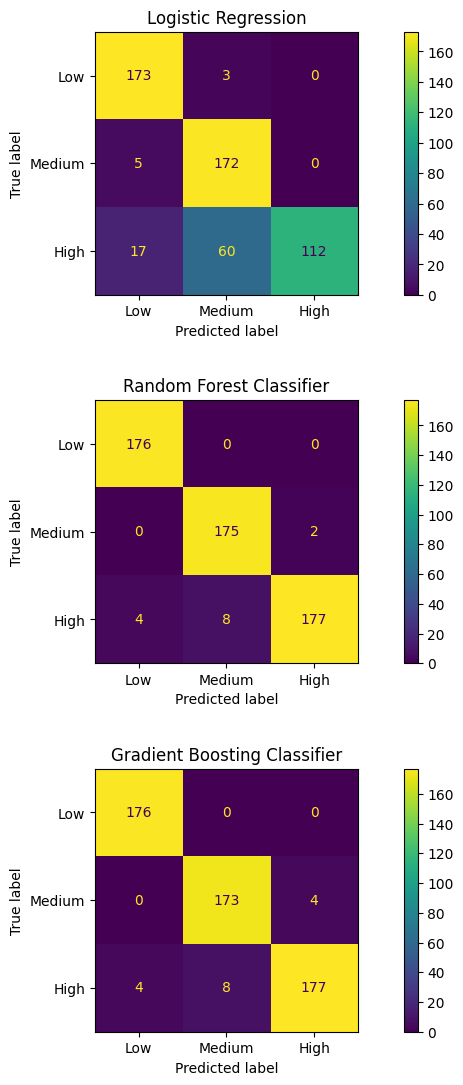

In [12]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Количество моделей
num_models = len(best_models_class)

# Создание фигуры и осей для отображения матриц ошибок
fig, ax = plt.subplots(num_models, 1, figsize=(12, 10), sharex=False, sharey=False)

# Перебор моделей и отображение матриц ошибок
for index, key in enumerate(best_models_class.keys()):
    c_matrix = best_models_class[key]["Confusion_matrix"]
    disp = ConfusionMatrixDisplay(
        confusion_matrix=c_matrix, display_labels=["Low", "Medium", "High"]
    ).plot(ax=ax.flat[index])
    disp.ax_.set_title(key)

# Настройка расположения подзаголовков
plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.1)
plt.show()


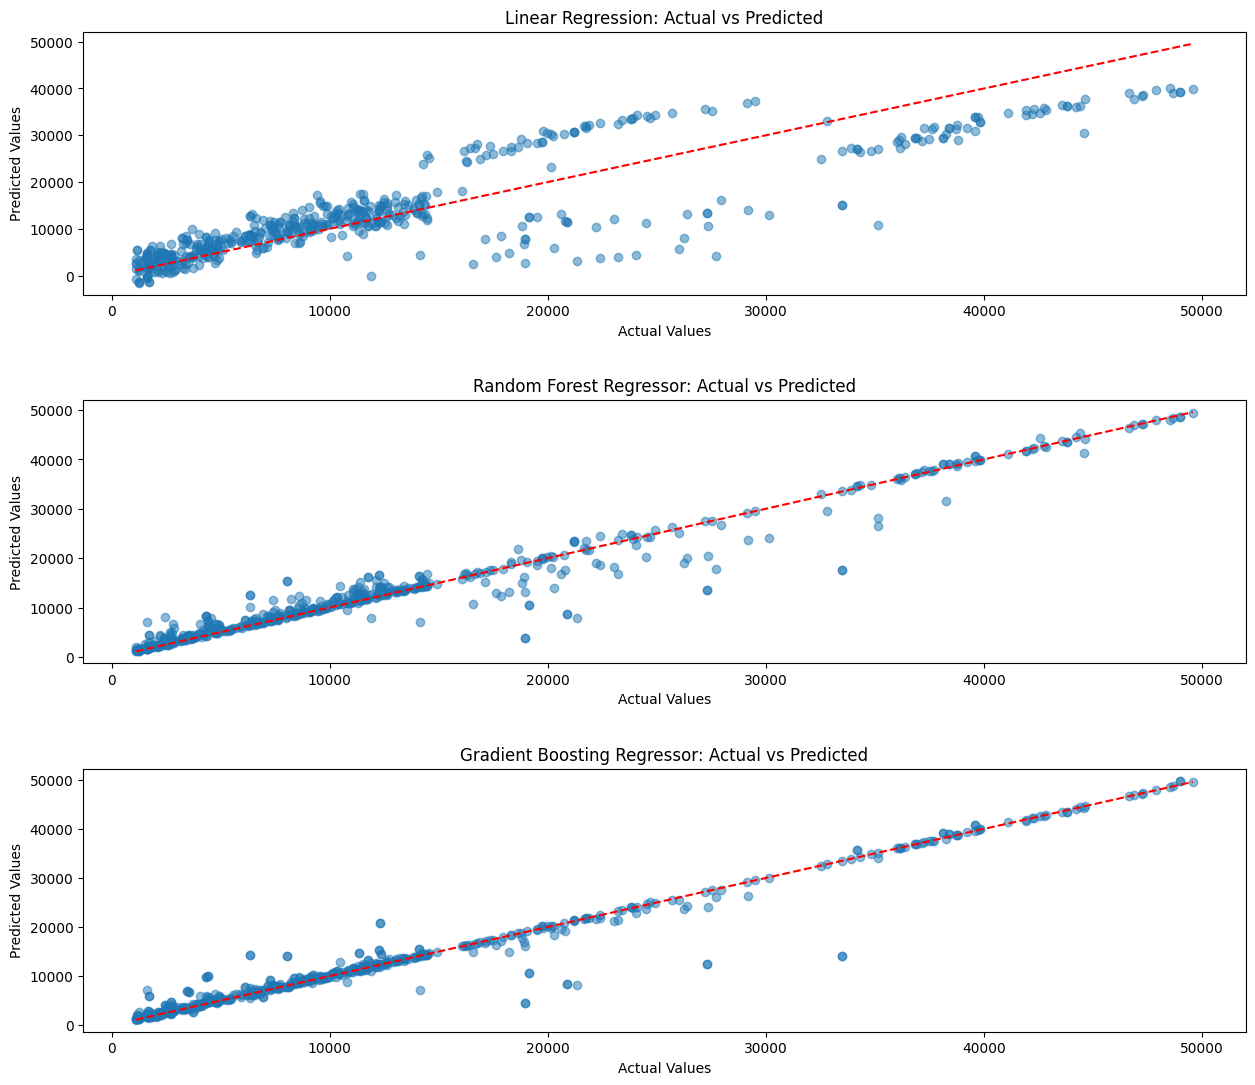

In [18]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Создание фигуры и осей для отображения графиков
fig, ax = plt.subplots(len(best_models_reg), 1, figsize=(15, 10), sharex=False, sharey=False)
ax = ax.flatten()

# Перебор моделей и отображение графиков
for index, (name, model_results) in enumerate(results_reg.items()):
    y_test_reg = y_test_reg
    y_pred_reg = model_results["preds_test"]

    # График фактических значений против предсказанных значений
    ax[index].scatter(y_test_reg, y_pred_reg, alpha=0.5)
    ax[index].plot([min(y_test_reg), max(y_test_reg)], [min(y_test_reg), max(y_test_reg)], color='red', linestyle='--')
    ax[index].set_xlabel('Actual Values')
    ax[index].set_ylabel('Predicted Values')
    ax[index].set_title(f'{name}: Actual vs Predicted')

# Настройка расположения подзаголовков
plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.1)
plt.show()
